# T-ABSA Random Forest Model using TF-IDF Embedding

Training a random forest model for T-ABSA. This model is trained using the Sentitel dataset. The dataset contains telecom related reviews downloaded from Twitter and Facebook 

### Exploring the training set

In [1]:
# Importing the libraries for preprocessing the reviews
# read in some helpful libraries

import os
import nltk                       # the natural langauage toolkit, open-source NLP
import pandas as pd               # pandas dataframe

#### 1. Loading the training dataset

In [2]:
data_dir = 'D:/jupyter/Year2_Research/Generate_Data/data/5_aspects/'


df = pd.read_csv(os.path.join(data_dir, "train_NLI.tsv"),sep="\t")

df.tail(4)

,id,sentence1,sentence2,label
20059,1168227041763823616,mtnugwhy did you disconnect my line from network,mtn - CustomerService,Negative
20060,1168227041763823616,mtnugwhy did you disconnect my line from network,mtn - Data,None
20061,1168227041763823616,mtnugwhy did you disconnect my line from network,mtn - General,None
20062,1168227041763823616,mtnugwhy did you disconnect my line from network,mtn - Network,None


#### 2. Visualising the training set using a word cloud 

In [3]:
from nltk.tokenize import word_tokenize

In [4]:
reviews = df.sentence1.str.cat(sep=' ')#function to split text into word

Top 10 words in the reviews before removing any stop words

In [5]:
tokens = word_tokenize(reviews)
vocabulary = set(tokens)
print(len(vocabulary))
frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:10]

7038


['i', 'the', 'airtelug', 'to', 'is', 'mtn', 'my', 'you', 'and', 'a']

Removing the stop words

In [6]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
tokens = [w for w in tokens if not w in stop_words]

Top 100 words after removing stop words

In [7]:
vocabulary = set(tokens)
print(len(vocabulary))
frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:5]

6908


['airtelug', 'mtn', 'network', 'data', 'internet']

Plotting a word cloud of the words in the reviews

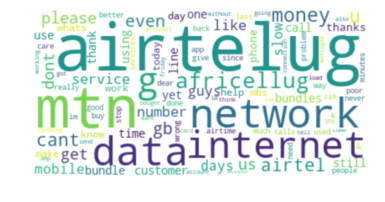

In [38]:
#importing the necessary libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(max_words=100,background_color="white").generate_from_frequencies(frequency_dist)
plt.imshow(wordcloud,interpolation="bicubic")
plt.axis("off")
plt.show()

####  3. Preprocessing the training set

shape of the training dataset

In [9]:
df.shape

(20063, 4)

#### Encoding the labels of the dataset.

The label 'None' is encoded as a 1, the 'Positive' label is encoded as a 2 and the 'Negative' label is encoded as a 0

In [10]:
y_train = df['label'].replace(['None','Positive','Negative'],[1,2,0])

y_train.head(4)

0    1
1    1
2    2
3    1
Name: label, dtype: int64

In [11]:
y_train.tail(4)

20059    0
20060    1
20061    1
20062    1
Name: label, dtype: int64

Splitting the labels from the reviews and target aspect pairs

In [12]:
x_cols = [x for x in df.columns if x != 'label']

# Split the data into two dataframes (one for the labels and the other for the independent variables)
X_data = df[x_cols]

In [13]:
X_data.tail()

,id,sentence1,sentence2
20058,1168227041763823616,mtnugwhy did you disconnect my line from network,mtn - Calls
20059,1168227041763823616,mtnugwhy did you disconnect my line from network,mtn - CustomerService
20060,1168227041763823616,mtnugwhy did you disconnect my line from network,mtn - Data
20061,1168227041763823616,mtnugwhy did you disconnect my line from network,mtn - General
20062,1168227041763823616,mtnugwhy did you disconnect my line from network,mtn - Network


Merging the reviews with the target-aspect pairs

In [14]:
X_data['concatinated'] = X_data['sentence1'] + ' ' + X_data['sentence2']
#X_data['concatinated'].values
X_data['concatinated'][20]

'i wan na take this adamount opportunity to thank africellug for keeping me online and also my data is about to be depleted can your people talk to my people we see a way forward  africell - Calls'

In [15]:
X_train = X_data['concatinated'].values
X_train[100]

'its a crazy weekend with africellug gb for ugx day gb for ugx days dial to activate you go kill me woawith these pretty internet bundles  africell - Network'

In [16]:
y_train[100]

1

### Embedding the reviews using TF-IDF and training the Random Forest model

Importing the libraries for carrying out TFID on the reviews

In [17]:
# read in some helpful libraries

import re                         # regular expression
from nltk.corpus import stopwords  
from gensim import parsing        # Help in preprocessing the data, very efficiently
import gensim
import numpy as np

In [18]:
# Function for preprocessing the reviews before training the RF model

def transformText(text):
    
    stops = set(stopwords.words("english"))
    
    # Convert text to lower
    text = text.lower()
    # Removing non ASCII chars    
    text = re.sub(r'[^\x00-\x7f]',r' ',text)
    
    # Strip multiple whitespaces
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
    
    # Removing all the stopwords
    filtered_words = [word for word in text.split() if word not in stops]
    
    # Removing all the tokens with lesser than 3 characters
    filtered_words = gensim.corpora.textcorpus.remove_short(filtered_words, minsize=3)
    
    # Preprocessed text after stop words removal
    text = " ".join(filtered_words)
    
    # Remove the punctuation
    text = gensim.parsing.preprocessing.strip_punctuation2(text)
    
    # Strip all the numerics
    text = gensim.parsing.preprocessing.strip_numeric(text)
    
    # Strip multiple whitespaces
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
    
    # Stemming
    return text

In [19]:
X_data['concatinated'] = X_data['concatinated'].map(transformText)

Printing a couple of rows after the preprocessing the reviews

In [20]:
print (X_data['concatinated'][0] , '\n')
print (X_data['concatinated'][10] , '\n')
print (X_data['concatinated'][20])

airtelug mulinga amatako tell used data bought staying robbery getting back africellug soonlemme replace simcard mscheew africell calls 

africellug awaiting follow check details africell calls 

wan take adamount opportunity thank africellug keeping online also data depleted people talk people see way forward africell calls


####  1. TF-IDF Embedding

In [21]:
## Get the word vocabulary out of the data

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()


X_train_counts = vectorizer.fit(X_data['concatinated'])

num_features = len(vectorizer.get_feature_names())

print("Number of Featurs", num_features)

Number of Featurs 6768


#### 2. Training the Random Forest classifier

In [23]:
X_train_tfidf = vectorizer.transform(X_data['concatinated'])

print(X_train_tfidf.shape)

(20063, 6768)


In [24]:
from sklearn.ensemble import RandomForestClassifier

# Fit a random forest to the training data, using 100 trees
forest = RandomForestClassifier(n_estimators = 100)

print("Fitting a random forest to labeled training data...")
forest = forest.fit(X_train_tfidf, y_train)

print("Fitting Completed")

Fitting a random forest to labeled training data...
Fitting Completed


### Evaluating the model

#### 1. Loading  and preprocessing the test set

In [25]:
# Loading the test set
data_dir_test = 'D:/jupyter/Year2_Research/Generate_Data/data/5_aspects/'

df_test = pd.read_csv(os.path.join(data_dir_test, "test_NLI.tsv"),sep="\t")

df_test['concatinated'] = df_test['sentence1'] + ' ' + df_test['sentence2']


In [26]:
df_test['concatinated'] = df_test['concatinated'].map(transformText)

In [27]:
X_test = df_test['concatinated'].values

y_test = df_test['label'].replace(['None','Positive','Negative'],[1,2,0]).values


print(X_test[:2])
print(y_test[:2])

['many tears eyes cant believe africellug network still even poor even main town centre crying mbarara uganda others africell calls'
 'many tears eyes cant believe africellug network still even poor even main town centre crying mbarara uganda others africell customerservice']
[1 1]


#### 2. Model predictions

In [29]:
X_test_tfidf  = vectorizer.transform(X_test)
print ('Dimension of TF-IDF vector :' , X_test_tfidf.shape)

Dimension of TF-IDF vector : (5669, 6768)


In [30]:
## Prediction

Y_predicted = forest.predict(X_test_tfidf)

#### 3. Evaluating the performance of the model

In [31]:
from  sklearn.metrics  import accuracy_score
print(accuracy_score(y_test, Y_predicted))

0.8572940553889575


In [32]:
Y_forest_score = forest.predict_proba(X_test_tfidf)
Y_forest_score

array([[0.16, 0.84, 0.  ],
       [0.15, 0.85, 0.  ],
       [0.18, 0.8 , 0.02],
       ...,
       [0.15, 0.84, 0.01],
       [0.07, 0.9 , 0.03],
       [0.35, 0.64, 0.01]])

In [33]:
import csv

# Open/Create a file to append data
csvFile_pred = open('prediction_score.csv', 'w')

#Use csv Writer
csvWriter_pred = csv.writer(csvFile_pred)

csvWriter_pred.writerow(['predicted','score_none','score_pos','score_neg'])

42

In [34]:
for f in range(len(Y_predicted)):
    csvWriter_pred.writerow([Y_predicted[f],Y_forest_score[f][1], Y_forest_score[f][0], Y_forest_score[f][2]])
csvFile_pred.close()

Checking on the save result files

In [35]:
len(df)

20063

In [36]:
dataframe = pd.read_csv('prediction_score.csv')
dataframe.tail(5)

,predicted,score_none,score_pos,score_neg
5664,1,0.80,0.19,0.01
5665,1,0.87,0.12,0.01
5666,1,0.84,0.15,0.01
5667,1,0.90,0.07,0.03
5668,1,0.64,0.35,0.01


#### 4. Performance based on the evaluation metrics

AUC per Aspect

aspect_strict_Accuracy

aspect_Macro_F1

aspect_Macro_AUC 

sentiment Accuracy

sentiment_Macro_AUC

In [37]:
# -*- coding: utf-8 -*-
"""
Created on Sun Oct 20 11:40:28 2019

@author: David
"""

### Code for evaluating the TABSA models

import collections

import numpy as np
import pandas as pd
from sklearn import metrics



def get_y_true():
#    """ 
#    Read file to obtain y_true.
#        
#    """
    true_data_file = "D:/jupyter/Year2_Research/Generate_Data/data/5_aspects/test_NLI.tsv"

    df = pd.read_csv(true_data_file,sep='\t')
    y_true = []
    for i in range(len(df)):
        label = df['label'][i]
        assert label in ['None', 'Positive', 'Negative'], "error!"
        if label == 'None':
            n = 1
        elif label == 'Positive':
            n = 2
        else:
            n = 0
        y_true.append(n)

    print(len(y_true))   
    return y_true

        
def get_y_pred():
#    """ 
#    Read file to obtain y_pred and scores.
#    """
               
    dataframe = pd.read_csv('prediction_score.csv')
    
    pred=[]
    score=[]



    for f in range(len(dataframe)):
        pred.append(dataframe.predicted[f])
        score.append([float(dataframe.score_pos[f]),float(dataframe.score_none[f]),float(dataframe.score_neg[f])])
                 
    return pred, score





def sentitel_strict_acc(y_true, y_pred):
    """
    Calculate "strict Acc" of aspect detection task of sentitel.
    """
    total_cases=int(len(y_true)/5)
    true_cases=0
    for i in range(total_cases):
        if y_true[i*5]!=y_pred[i*5]:continue
        if y_true[i*5+1]!=y_pred[i*5+1]:continue
        if y_true[i*5+2]!=y_pred[i*5+2]:continue
        if y_true[i*5+3]!=y_pred[i*5+3]:continue
        if y_true[i*5+4]!=y_pred[i*5+4]:continue
        true_cases+=1
    aspect_strict_Acc = true_cases/total_cases

    return aspect_strict_Acc


def sentitel_macro_F1(y_true, y_pred):
    """
    Calculate "Macro-F1" of aspect detection task of sentitel.
    """
    p_all=0
    r_all=0
    count=0
    for i in range(len(y_pred)//5):
        a=set()
        b=set()
        for j in range(5):
            if y_pred[i*5+j]!=1:
                a.add(j)
            if y_true[i*5+j]!=1:
                b.add(j)
        if len(b)==0:continue
        a_b=a.intersection(b)
        if len(a_b)>0:
            p=len(a_b)/len(a)
            r=len(a_b)/len(b)
        else:
            p=0
            r=0
        count+=1
        p_all+=p
        r_all+=r
    Ma_p=p_all/count
    Ma_r=r_all/count
    aspect_Macro_F1 = 2*Ma_p*Ma_r/(Ma_p+Ma_r)

    return aspect_Macro_F1


def sentitel_AUC_Acc(y_true, score):
    """
    Calculate "Macro-AUC" of both aspect detection and sentiment classification tasks of sentitel.
    Calculate "Acc" of sentiment classification task of sentitel.
    """
    # aspect-Macro-AUC
    aspect_y_true=[]
    aspect_y_score=[]
    aspect_y_trues=[[],[],[],[],[]]
    aspect_y_scores=[[],[],[],[],[]]
    for i in range(len(y_true)):
        if y_true[i]>0:
            aspect_y_true.append(0)
        else:
            aspect_y_true.append(1) # "None": 1
        tmp_score=score[i][0] # probability of "None"
        aspect_y_score.append(tmp_score)
        aspect_y_trues[i%5].append(aspect_y_true[-1])
        aspect_y_scores[i%5].append(aspect_y_score[-1])

    aspect_auc=[]
    for i in range(5):
        aspect_auc.append(metrics.roc_auc_score(aspect_y_trues[i], aspect_y_scores[i]))
        
    print("AUC per aspect:\t Calls, CustomerService, Data, General, Network")
    print(aspect_auc)
    aspect_Macro_AUC = np.mean(aspect_auc)
    
    # sentiment-Macro-AUC
    sentiment_y_true=[]
    sentiment_y_pred=[]
    sentiment_y_score=[]
    sentiment_y_trues=[[],[],[],[],[]]
    sentiment_y_scores=[[],[],[],[],[]]
    for i in range(len(y_true)):
        if y_true[i]>0:
            sentiment_y_true.append(y_true[i]-1) # "Postive":0, "Negative":1
            tmp_score=score[i][2]/(score[i][1]+score[i][2])  # probability of "Negative"
            sentiment_y_score.append(tmp_score)
            if tmp_score>0.5:
                sentiment_y_pred.append(1) # "Negative": 1
            else:
                sentiment_y_pred.append(0)
            sentiment_y_trues[i%5].append(sentiment_y_true[-1])
            sentiment_y_scores[i%5].append(sentiment_y_score[-1])

    sentiment_auc=[]
    for i in range(5):
        sentiment_auc.append(metrics.roc_auc_score(sentiment_y_trues[i], sentiment_y_scores[i]))
    sentiment_Macro_AUC = np.mean(sentiment_auc)

    # sentiment Acc
    sentiment_y_true = np.array(sentiment_y_true)
    sentiment_y_pred = np.array(sentiment_y_pred)
    sentiment_Acc = metrics.accuracy_score(sentiment_y_true,sentiment_y_pred)

    return aspect_Macro_AUC, sentiment_Acc, sentiment_Macro_AUC

#####################################################################


y_true = (get_y_true())
y_pred, score = get_y_pred()

result = collections.OrderedDict()

aspect_strict_Acc = sentitel_strict_acc(y_true, y_pred)
aspect_Macro_F1 = sentitel_macro_F1(y_true, y_pred)
aspect_Macro_AUC, sentiment_Acc, sentiment_Macro_AUC = sentitel_AUC_Acc(y_true, score)
result = {'aspect_strict_Acc': aspect_strict_Acc,
                'aspect_Macro_F1': aspect_Macro_F1,
                'aspect_Macro_AUC': aspect_Macro_AUC,
                'sentiment_Acc': sentiment_Acc,
                'sentiment_Macro_AUC': sentiment_Macro_AUC}


print(result)

nameHandle = open('RF_tfidf_evaluation_results.txt', 'w')

nameHandle.write('aspect_strict_Acc:\t'+ str(aspect_strict_Acc))
nameHandle.write('\naspect_Macro_F1:\t' + str(aspect_Macro_F1))
nameHandle.write('\naspect_Macro_AUC:\t' + str(aspect_Macro_AUC))
nameHandle.write('\n\nsentiment_Acc:\t' + str(sentiment_Acc))
nameHandle.write('\nsentiment_Macro_AUC:\t' + str(sentiment_Macro_AUC))
nameHandle.close()

5669
AUC per aspect:	 Calls, CustomerService, Data, General, Network
[0.8848180266940932, 0.8410555136084904, 0.8492237734055927, 0.909020618556701, 0.86456996510188]
{'aspect_strict_Acc': 0.39452780229479256, 'aspect_Macro_F1': 0.32659151946368187, 'aspect_Macro_AUC': 0.8697375794733514, 'sentiment_Acc': 0.9670306593868123, 'sentiment_Macro_AUC': 0.9115279392081035}
